In [31]:
%matplotlib inline  
import sys, ast, math, datetime
import pandas as pd
import datetime as dt
import numpy as np
from time import time
from pprint import pprint
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
from collections import Counter
import warnings
warnings.filterwarnings(action='ignore')

Setting up function options and function tools.

In [32]:
data_path = "data/"
m = pd.read_csv(data_path + "movies_postprocessing.csv").drop("Unnamed: 0", axis=1)
entities = {}
for col in ["genres", "keywords","plot_keywords","all_keywords" ,"production_companies", "production_countries", "spoken_languages"]:
    m[col] = pd.Series(ast.literal_eval(b) for b in m[col])
m["release_date"] = m["release_date"].apply(lambda x: dt.datetime.strptime(x,"%Y-%m-%d"))

#### Utility Functions

In [33]:
mlb = MultiLabelBinarizer()

def p(x):
    print(x)

def safe_add(dict_,key,x):
    if key not in dict_.keys():
        dict_[key] = 0 
    dict_[key] += x

#Get most common keywords
def get_most_common_with_counts(key, count, df = m):
    most_common_keywords = sorted(Counter([a for b in df[key] for a in b]).items(), key = lambda kv: kv[1], reverse=True)
    return most_common_keywords[:count]
    

def get_most_common(key, count, df = m):
    most_common_keywords = sorted(Counter([a for b in df[key] for a in b]).items(), key = lambda kv: kv[1], reverse=True)
    most_common_keywords = most_common_keywords[:count]
    most_common_keywords = [a for a,b in most_common_keywords]
    return most_common_keywords

# Building Prediction Models

### Preparation

In [9]:
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score
from scipy.stats import spearmanr, pearsonr
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

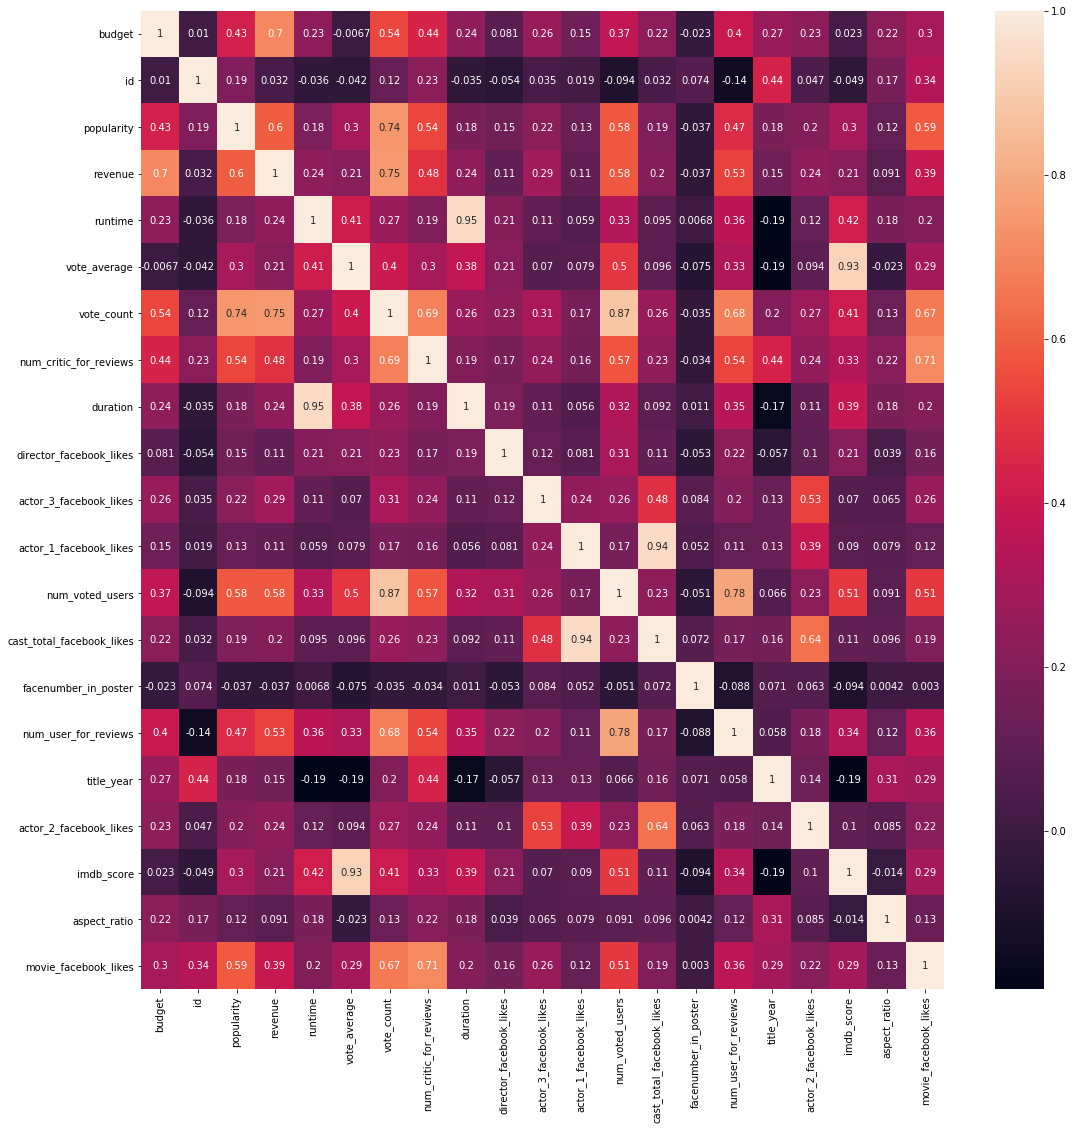

In [20]:
corr = m.drop([ 'profit',
       'ret_rate', 'rev_rate', 'log_rev_rate', 'log_budget', 'log_revenue',
       'Profitable', 'all_keywords', 'lang_en'], axis=1).corr()
f, ax = plt.subplots(figsize=(18,18))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True,)

In [10]:
def repl_cat_n_mostfrequent(ser, n=40):
    largest = ser.value_counts()[:n]
    return ser.apply(lambda x: str(x) if x in largest.index else "other").astype('category')

def get_categorical_list(df, col, prefix, cut = 100):
    fit_transform = mlb.fit_transform(df[col]) 
    most_common = [a for a,b in get_most_common_with_counts(col,cut)]
    newdf= pd.DataFrame( fit_transform ,columns = [prefix + "_"+a for a in mlb.classes_],index=df.index )
    newdf = newdf[[prefix + "_"+a for a in mlb.classes_ if a in most_common]]
    return newdf

def join_categorical_list(df, col, prefix, cut = 100):
    newdf = get_categorical_list(df, col, prefix, cut)
    newdf = df.join(newdf, how="left", lsuffix='_l', rsuffix='_r',)
    newdf = newdf.drop([col], axis = 1)
    return newdf

def join_PCA_categorical_list(df, col, prefix, cut = 100000, n_components=20):
    X = get_categorical_list(df, col, prefix, cut)
    pca = PCA(n_components=n_components)
    pca.fit(X)
    X_pca = pd.DataFrame(pca.transform(X))
    print(col+": Explained variance: ", pca.explained_variance_ratio_, sum(pca.explained_variance_ratio_))
    X_pca.columns=["PCA_"+prefix + "_"+str(i) for i in range(n_components)]
    newdf = X_pca
    newdf = df.join(newdf, how="left",lsuffix='_l', rsuffix='_r',)
    newdf = newdf.drop([col], axis = 1)
    return newdf

# Adding Lingusitic Features

In [11]:
# import gensim.downloader as api
# #Note: Takes ~1 min to download and loaa 128MB word embeddings from the internet.
# word_vectors = api.load("glove-wiki-gigaword-100")
# word_vectors.save(data_path + "glove-wiki-gigaword-100.model")

In [1]:
#may ignore if already downloaded
import nltk
nltk.download('stopwords')

from word_utils import *
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords 
from gensim.models import Word2Vec
from gensim.corpora import Dictionary
from gensim.models import KeyedVectors
from gensim.models.tfidfmodel import TfidfModel
from gensim.matutils import sparse2full
from sklearn.svm import SVR
from matplotlib import pyplot
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from eli5.transform import transform_feature_names

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhengyuanma/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
def get_kw_for_series(series_name, plotkeywords = False):
    col = "plot_keywords" if plotkeywords else "keywords"
    return list(set([a for b in m[m.original_title.str.contains(series_name)][col] for a in b]))

def get_representation(word_to_ind, result, word):
    if word not in word_to_ind.keys(): return None
    return result[word_to_ind[word]]

def get_distict(l, to_remove):
    return [w for w in l if w not in to_remove]

def plot_different_series(ser_list, model, plotkeywords = False, twodmodel = None):    
    result = twodmodel
    if result is None:
        X = model[model.wv.vocab]
        pca = PCA(n_components=2)
        result = pca.fit_transform(X)
    
    all_kw = [get_kw_for_series(a, plotkeywords =plotkeywords) for a in ser_list]
    all_list = Counter([a for b in all_kw for a in b])
    to_remove = [a for a, cnt in all_list.items() if cnt != 1]
    all_kw = [get_distict(a, to_remove) for a in all_kw]
    all_kw = dict(zip(ser_list, all_kw))

    fig, ax = plt.subplots(figsize=(10, 10))
    for k, kws in all_kw.items():
        word_to_ind = {w:i for i,w in enumerate(model.wv.vocab)}
        coords = {w:get_representation(word_to_ind, result, w) for w in kws}
        coords = {w:v for w,v in coords.items() if v is not None}
        xs = [a[0] for a in coords.values()]
        ys = [a[1] for a in coords.values()]

        ax.plot(xs, ys, marker='o', linestyle='', 
                ms=8, alpha=0.3, label=k)
        for w,xy in coords.items():
            ax.annotate(w, xy=xy)
    ax.legend()
    plt.show()

#### From Overview

In [27]:
word_vectors = KeyedVectors.load(data_path + "glove-wiki-gigaword-100.model")

In [12]:
#Lemmatization and NLP preprocessing takes a bit of time (~1-2 mins)
normalized_overviews = m.overview.apply(lambda x: lemmatize_verbs(normalize(nltk.word_tokenize(x.decode('utf-8')))))

In [14]:
X = word_vectors[word_vectors.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)

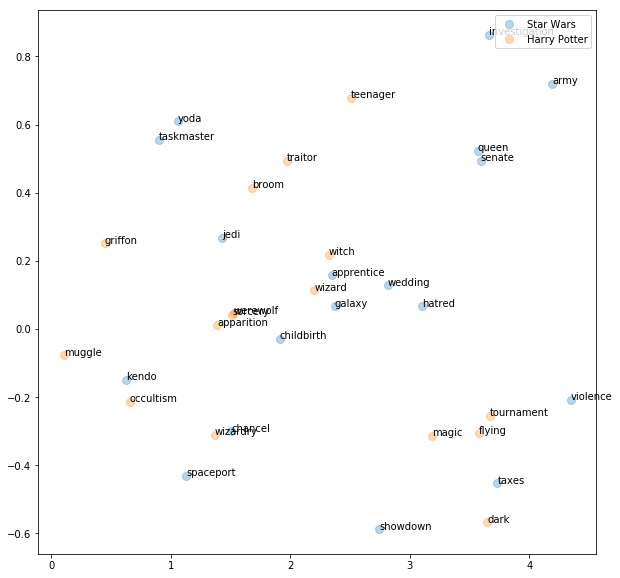

In [15]:
ser_list = ["Harry Potter", "Star Wars"]
plot_different_series(ser_list, word_vectors, False, twodmodel=result)

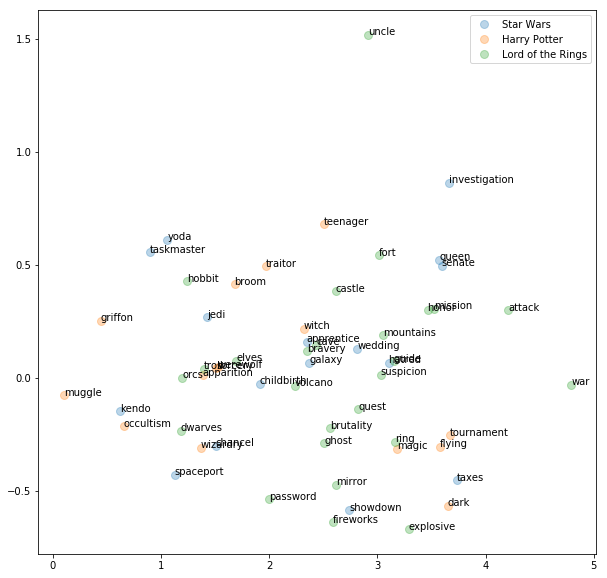

In [16]:
ser_list = ["Harry Potter", "Lord of the Rings", "Star Wars"]
plot_different_series(ser_list, word_vectors_copy, False, twodmodel=result)

#### From Keywords

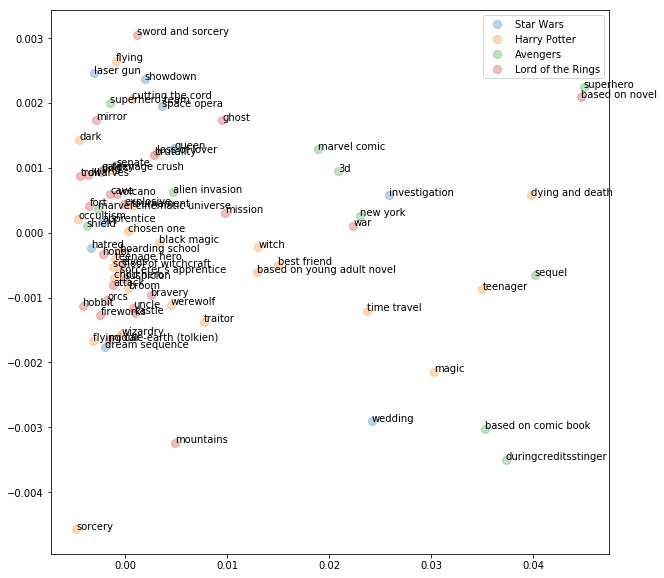

In [17]:
docs_ = m_exp.keywords
model_ = Word2Vec(docs_, size=300, min_count=3, workers=5)
# X = model_[model_.wv.vocab]
# pca = PCA(n_components=2)
# result = pca.fit_transform(X)

ser_list = ["Harry Potter", "Avengers", "Lord of the Rings", "Star Wars"]
plot_different_series(ser_list, model_, False)

#### From Plot_Keywords

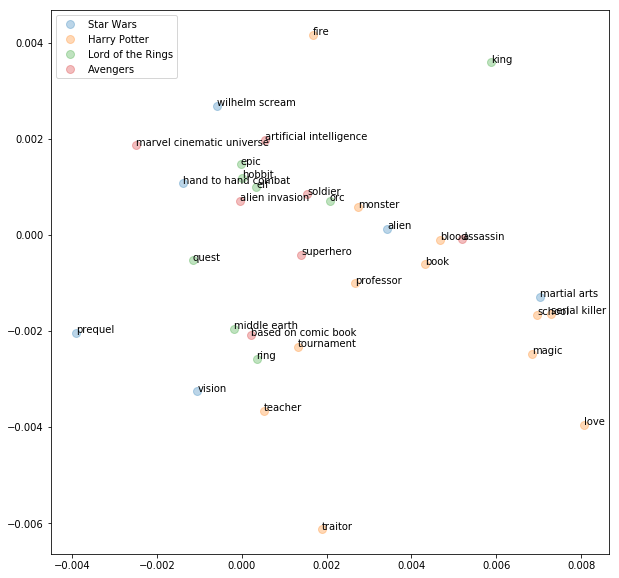

In [18]:
docs_ = m_exp.plot_keywords
model_ = Word2Vec(docs_, size=200, min_count=3, workers=5)
X = model_[model_.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)

ser_list = ["Harry Potter", "Lord of the Rings", "Avengers", "Star Wars"]
plot_different_series(ser_list, model_, True)

# Building the Model

In [34]:
## Removal of Variables
m_exp = m.copy()
m_exp = m_exp.reset_index().drop("index", axis=1)
companies_to_keep = [k for k,v in get_most_common_with_counts("production_companies", 100000) if v >= 10]
m_exp.production_companies = m_exp.production_companies.apply(lambda x: [a for a in x if a in companies_to_keep])

# Feature Generation

#### Adding Actor Network Features
The actor network features (Degree and PageRank) were computed in Gephi. A copy as also computed in 'Actors Pagerank.ipynb'. We add them as features to our model.

In [35]:
actor_centrality = pd.read_csv(data_path + "actors_node_measures.csv")
actor_centrality= actor_centrality[["Id","Weighted Degree","count_pagerank","revenue_pagerank", "imdb_pagerank"]]
actor_centrality= actor_centrality.rename({"Weighted Degree":"degree"}, axis=1).set_index("Id")

In [36]:
for i in range(1,4):
    for col in ["degree","count_pagerank","revenue_pagerank","imdb_pagerank"]:
        m["actor_{}_{}".format(str(i), col)] = m["actor_{}_name".format(i)].map(lambda x:
                    0 if x not in actor_centrality.index else actor_centrality.loc[x][col])

#### Average Return Rates for Keywords
These take a long time to generate (~5 mins) and are presented as an experiment. They worked quite well as predictors (>86% R2) but we don't end up using them in the end because we don't want to be predicting return rates with return rates.

In [ ]:
# keywords = get_most_common_with_counts("keywords", 10000000)

# def convert_to_med_column(cat_list_col, val, target_col):
#     return np.median(m[m[cat_list_col].apply(lambda x: val in x)][target_col])

# m["keywords_log_rr"] = m.keywords.apply(lambda x: 
#                                         sorted([convert_to_med_column("keywords",a,"ret_rate")
#                                                  for a in x],reverse = True))

In [ ]:
# m["keywords_log_rr"] = m["keywords_log_rr"].apply(lambda x: sorted(x, reverse=True))
# m["med_keywords_log_rr"] = m["keywords_log_rr"].apply(lambda x: np.median(x))
# for i in range(5) + [-1]:
#     m["keywords_log_rr"+str(i)] = m["keywords_log_rr"].apply(lambda x: x[i] if i < len(x) and len(x)>0 else 0)

In [ ]:
# m["genre_log_rr"] = m.keywords.apply(lambda x: 
#                                         sorted([convert_to_med_column("genres",a,"log_rev_rate")
#                                              for a in x], reverse=True))
# m["med_genre_log_rr"] = m["genre_log_rr"].apply(lambda x: np.median(x))
# for i in range(3) + [-1]:
#     m["genre_log_rr"+str(i)] = m["genre_log_rr"].apply(lambda x: x[i] if i < len(x) and len(x)>0 else 0)                                     

In [ ]:
# m["plotkw_log_rr"] = m.plot_keywords.apply(lambda x: 
#                                         sorted([convert_to_med_column("plot_keywords",a,"log_rev_rate")
#                                             for a in x], reverse=True))
# m["med_plotkw_log_rr"] = m["plotkw_log_rr"].apply(lambda x: np.median(x))
# for i in range(5) + [-1]:
#     m["plotkw_log_rr"+str(i)] = m["plotkw_log_rr"].apply(lambda x: x[i] if i < len(x) and len(x)>0 else 0)                                     

In [ ]:
# kws_rrs = [
# "original_title"]+[a for a in m_reg.columns if "keywords_log_rr" in a or "genre_log_rr" in a or "plotkw_log_rr" in a]
# m[kws_rrs].to_csv(data_path + "kws_rrs.csv")

In [24]:
kws_rrs = pd.read_csv(data_path + "kws_rrs.csv")
m_exp["original_title"] = m_exp["original_title"].astype(str)
kws_rrs["original_title"] = kws_rrs["original_title"].astype(str)
m_exp = m_exp.merge(kws_rrs, on="original_title", how="left")

#### Add lingustic features

Requires to have first run the 'Adding Linguistic Features' section above to get the requisite language models. We add reduced representations (using PCA, generally in dimension 10) of the keywords attached to each movie to our model as features.

In [37]:
max_window = 50

def safe_get_word_vector(model, word):
    if word not in model.wv.vocab:
        return [0]* model.vector_size
    return model[word]

def get_tfidf_document_embeddings(docs, model, prefix, no_below=5, no_above=0.2, reduce_dim=100):
    docs = m_exp.keywords
    docs_dict = Dictionary(docs)
    docs_dict.filter_extremes(no_below=no_below, no_above=no_above)
    docs_dict.compactify()

    docs_corpus = [docs_dict.doc2bow(doc) for doc in docs]
    model_tfidf = TfidfModel(docs_corpus, id2word=docs_dict)
    docs_tfidf  = model_tfidf[docs_corpus]

    #Generage matrix of rows (movie overviews) to columns (tfidf terms)
    docs_vecs   = np.vstack([sparse2full(c, len(docs_dict)) for c in docs_tfidf])

    tfidf_emb_vecs = np.vstack([safe_get_word_vector(model, docs_dict[i]) 
                                for i in range(len(docs_dict))])

    docs_emb = np.dot(docs_vecs, tfidf_emb_vecs) 
    
    reduce_dim = min(model.vector_size, reduce_dim)
    pca = PCA(n_components=reduce_dim)
    docs_emb = pca.fit_transform(docs_emb)
    print(col+": Explained variance: ", pca.explained_variance_ratio_, sum(pca.explained_variance_ratio_))

    cols = [prefix+"_WV_"+str(i) for i in range(reduce_dim)]
    docs_emb = pd.DataFrame(docs_emb, columns= cols)
    return docs_emb


In [38]:
docs_emb = get_tfidf_document_embeddings(normalized_overviews, word_vectors, "GL", no_below=10, no_above=0.2, reduce_dim=10)
m_exp = m_exp.join(docs_emb, how="left")

docs_ = m_exp.keywords
model_ = Word2Vec(docs_, size=300, min_count=5, window = max_window)
docs_emb = get_tfidf_document_embeddings(docs_, model_, "K", no_below=5, no_above=0.2, reduce_dim=10)
m_exp = m_exp.join(docs_emb, how="left")

docs_ = m_exp.plot_keywords
model_ = Word2Vec(docs_, size=200, min_count=5, workers=5, window = max_window)
docs_emb = get_tfidf_document_embeddings(docs_, model_, "PK", no_below=5, no_above=0.2, reduce_dim=10)
m_exp = m_exp.join(docs_emb, how="left")

docs_ = m_exp.all_keywords
docs_emb = get_tfidf_document_embeddings(docs_, word_vectors, "ALL", no_below=10, no_above=0.2, reduce_dim=10)
m_exp = m_exp.join(docs_emb, how="left")

('imdb_pagerank: Explained variance: ', array([0.2336574 , 0.07929778, 0.06684498, 0.05894284, 0.03519881,
       0.03283357, 0.03054102, 0.02520922, 0.02111114, 0.0203465 ]), 0.6039832486274086)
('imdb_pagerank: Explained variance: ', array([9.9447417e-01, 1.0685713e-04, 8.1626502e-05, 7.5028402e-05,
       6.8755966e-05, 6.6933950e-05, 6.2562714e-05, 6.0649847e-05,
       5.7924586e-05, 5.4751727e-05], dtype=float32), 0.9951092634146335)
('imdb_pagerank: Explained variance: ', array([0.08719572, 0.01977284, 0.01690578, 0.01640768, 0.01518961,
       0.01450751, 0.01406743, 0.01388966, 0.01357997, 0.01341901]), 0.22493521171682326)
('imdb_pagerank: Explained variance: ', array([0.2336574 , 0.07929778, 0.06684498, 0.05894284, 0.03519826,
       0.03283153, 0.03054145, 0.02521659, 0.02109614, 0.02034487]), 0.6039718429985148)


#### Using featuretools to automatically generate features (unimplemented)

In [ ]:
# Automatic feature generation with featuretools.
# import featuretools as ft
# m_hash = m.drop(["genres", "keywords", "production_companies", "production_countries", "spoken_languages",'plot_keywords',"all_keywords"], axis = 1)
# es = ft.EntitySet(id = 'movies')
# es = es.entity_from_dataframe(entity_id = 'original_title', dataframe = m_hash, 
#                               index = 'id', time_index = 'release_date', 
#                               variable_types = {'lang_en': ft.variable_types.Categorical,
#                                                'country': ft.variable_types.Categorical,})

# pass

### Prepare Data

#### Prepare and Expand Categorical Features

In [39]:
un_regressable_cols = ['id', 'original_title','original_language', 'tagline', 'title', 'release_date'] + \
                        [a for a in m.columns if a[-5:] == '_name']

def prepare_regress_data(df):    
    m_reg = df
    m_reg['month'] = m_reg['release_date'].apply(lambda x: x.month).astype('category')
    m_reg['day'] = m_reg['release_date'].apply(lambda x: x.day).astype('int')
    m_reg['year'] = m_reg['release_date'].apply(lambda x: x.year).astype('category')
    m_reg['content_rating'] = m_reg['content_rating'].astype('category')

    m_reg.director_name = repl_cat_n_mostfrequent(m_reg.director_name, 30)
    m_reg.actor_1_name = repl_cat_n_mostfrequent(m_reg.actor_1_name, 30)
    m_reg.country = repl_cat_n_mostfrequent(m_reg.country, 10)
    m_reg.year = repl_cat_n_mostfrequent(m_reg.year, 10)
#     m_reg = join_categorical_list(m_reg, "production_companies", "PC", cut = 40)
    m_reg = join_PCA_categorical_list(m_reg, "production_companies", "PC", n_components=10)
    m_reg = join_PCA_categorical_list(m_reg, "all_keywords", "KEY", n_components=10)
    m_reg = join_categorical_list(m_reg, "production_countries", "CO", cut = 5)
    m_reg = join_categorical_list(m_reg, "spoken_languages", "SL", cut = 8)
    m_reg = join_PCA_categorical_list(m_reg, "genres", "G", n_components=4)
#     m_reg = join_categorical_list(m_reg, "genres", "G", cut = 100)
    
    m_reg = m_reg.select_dtypes(exclude=[object])
    m_reg = m_reg.drop([a for a in un_regressable_cols if a in m_reg.columns], axis=1)
    
    for col in m_reg.columns:
        if m_reg.nunique()[col] <=2:
            m_reg[col] = m_reg[col].astype("category")
        
    return m_reg

m_reg = prepare_regress_data(m_exp)

('production_companies: Explained variance: ', array([0.0681433 , 0.06099906, 0.05312868, 0.04480894, 0.03733467,
       0.03041616, 0.02297752, 0.02206966, 0.0211307 , 0.02025177]), 0.381260468320053)
('all_keywords: Explained variance: ', array([0.00802975, 0.00692072, 0.00576628, 0.0051367 , 0.0047224 ,
       0.00442698, 0.00428189, 0.0041629 , 0.00395006, 0.00375061]), 0.05114827545688026)
('genres: Explained variance: ', array([0.20347229, 0.18347557, 0.10263906, 0.08373625]), 0.5733231724315818)


### Load Model Trainer

In [40]:
def run_model(m_reg, target="profit",
              numeric_features = ["budget"],
              categorical_features = [],
              other_features = [],
              regressor = RandomForestRegressor(),
             automate_features_select = False,
             grid_search_params = None, cv = False):
    
    cols_to_keep = [target]+ numeric_features + categorical_features + other_features
    m_reg_fin = m_reg[cols_to_keep]
    
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
         ('scaler', StandardScaler())])
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])

    if automate_features_select:
        model = Pipeline(steps=[
                          ('preprocessor', preprocessor),
                          ('feature_selection', SelectFromModel(LassoCV(cv=5))),
                          ('regressor', regressor)])
    else:
        model = Pipeline(steps=[
                          ('preprocessor', preprocessor),
                          ('regressor', regressor)])
    
    X = m_reg_fin.drop(target, axis=1)
    y = m_reg_fin[target]
    orig_X_used = X
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    if grid_search_params is not None:
        grid_search =  GridSearchCV(model, grid_search_params, cv=5,
                               n_jobs=-1, verbose=1)
        print("Performing grid search...")
        t0 = time()
        grid_search.fit(X, y)
        print("done in %0.3fs" % (time() - t0))
        print("Best score: %0.3f" % grid_search.best_score_)
        best_parameters = grid_search.best_estimator_.get_params() 
        model = grid_search.best_estimator_
    if cv:
        cv = ShuffleSplit(n_splits=5, test_size=0.2)
        scores = []
        for i in range(3):
            new_scores = list(cross_val_score(model, X,y, cv=cv))
            scores += new_scores
        scores = np.array(scores)
        print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))
        print(scores)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    test_score = r2_score(y_test, y_pred)
    spearman = spearmanr(y_test, y_pred)
    pearson = pearsonr(y_test, y_pred)

    print('Test data R-2 score: ',  test_score)
    print('Test data Spearman correlation: ',spearman[0])
    print('Test data Pearson correlation: ', pearson[0])

    print("model score: %.3f" % model.score(X_test, y_test))
    
    cat_cols = orig_X_used.select_dtypes(include=["category"]).columns
    new_cols = list(model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names())
    final_cols = [a for a in orig_X_used.columns if a not in cat_cols] + new_cols
    columns_used = dict(zip(final_cols, model.named_steps['feature_selection'].get_support()))
    print("Final model used was:")
    print(model.named_steps['regressor'])
    print("Columns used were: ")
    print([k for k,v in columns_used.items() if v])
    print("Columns not used were: ")
    print([k for k,v in columns_used.items() if not v])

    return model

#### Predicting Profits

##### Using SVM, Random Forest

In [41]:
import pickle

In [43]:
this_target = "log_rev_rate"
additional_to_remove = ["revenue", "log_revenue", 'profit', 'ret_rate', 'rev_rate', "log_rev_rate"]

param_grid = [
  {'regressor': [SVR()], 'regressor__C': np.array([0.1, 1, 10]),
   'regressor__gamma': ["scale", "auto"], 'regressor__kernel': ['rbf']},
 ]

categorics = list(m_reg.select_dtypes(include=["category"]).columns)
numerics = list(m_reg.select_dtypes(include=[np.number]).columns)
others = [a for a in m_reg.columns if a not in categorics and a not in numerics]

model_log_rev_rate_svm = run_model(m_reg, target = this_target,
          numeric_features = [a for a in numerics if a not in additional_to_remove],
          categorical_features = [a for a in categorics if a not in additional_to_remove],
          other_features = [a for a in others if a not in additional_to_remove],
         regressor = SVR(gamma='scale', C=1.0, epsilon=0.2),
         automate_features_select = True, grid_search_params = None)

pickle.dump( model_log_rev_rate_svm, open( data_path+"models/model_log_rev_rate_svm.pickle", "wb" ) )

('Test data R-2 score: ', 0.5273350312989773)
('Test data Spearman correlation: ', 0.8071068075544257)
('Test data Pearson correlation: ', 0.747889561635468)
model score: 0.527
Final model used was:
SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma='scale',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
Columns used were: 
[u'x9_0', u'x5_other', 'PCA_G_1', 'PCA_G_2', 'PCA_G_3', 'day', 'GL_WV_1', 'GL_WV_2', 'GL_WV_5', 'GL_WV_4', 'GL_WV_7', 'title_year', 'runtime', 'num_voted_users', 'aspect_ratio', 'ALL_WV_9', 'ALL_WV_4', 'ALL_WV_2', 'ALL_WV_1', 'PCA_PC_0', 'PCA_PC_3', 'PCA_PC_2', 'PCA_PC_5', 'PCA_PC_4', 'PCA_PC_6', u'x1_PG', 'actor_3_facebook_likes', u'x1_PG-13', 'vote_count', 'num_critic_for_reviews', 'director_facebook_likes', 'PCA_KEY_0', 'PCA_KEY_1', 'PCA_KEY_2', 'PCA_KEY_3', 'PCA_KEY_4', 'PCA_KEY_9', 'num_user_for_reviews', u'x5_2011', u'x1_R', 'budget', u'x13_0', u'x14_0', 'vote_average', 'popularity', 'K_WV_2', 'K_WV_1', 'K_WV_6', 'K_WV_7

In [45]:
this_target = "log_rev_rate"
additional_to_remove = ["revenue", "log_revenue", 'profit', 'ret_rate', 'rev_rate', "log_rev_rate"]

param_grid = [
    {'regressor': [RandomForestRegressor()], 'regressor__max_depth': [15, None],
     'regressor__min_samples_leaf': [1, 4], 'regressor__min_samples_split': [4, 10],
     'regressor__n_estimators': np.array([100, 400])},
 ]

categorics = list(m_reg.select_dtypes(include=["category"]).columns)
numerics = list(m_reg.select_dtypes(include=[np.number]).columns)
others = [a for a in m_reg.columns if a not in categorics and a not in numerics]

model_log_rev_rate_rf = run_model(m_reg, target = this_target,
          numeric_features = [a for a in numerics if a not in additional_to_remove],
          categorical_features = [a for a in categorics if a not in additional_to_remove],
          other_features = [a for a in others if a not in additional_to_remove],
         regressor = RandomForestRegressor(),
         automate_features_select = True, grid_search_params = None)

pickle.dump( model_log_rev_rate_rf, open( data_path+"models/model_log_rev_rate_rf.pickle", "wb" ) )

('Test data R-2 score: ', 0.646668210313915)
('Test data Spearman correlation: ', 0.8185474729206552)
('Test data Pearson correlation: ', 0.8071213852172305)
model score: 0.647
Final model used was:
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
Columns used were: 
[u'x9_0', u'x5_other', 'PCA_G_1', 'PCA_G_2', 'PCA_G_3', 'day', 'GL_WV_8', 'GL_WV_1', 'GL_WV_2', 'GL_WV_7', 'GL_WV_6', u'x0_Australia', u'x4_4', u'x4_1', u'x1_Not Rated', u'x4_9', 'title_year', 'num_voted_users', 'aspect_ratio', 'ALL_WV_9', 'ALL_WV_4', 'ALL_WV_2', 'ALL_WV_1', 'PCA_PC_9', 'actor_2_facebook_likes', 'PCA_PC_0', 'PCA_PC_3', 'PCA_PC_2', 'PCA_PC_5', 'PCA_PC_4', 'PCA_PC_7', 'PCA_PC_6

In [46]:
def remove_cols(orig, to_rem):
    return [a for a in orig if a not in to_rem]

this_target = "log_rev_rate"
additional_to_remove = ["revenue", "log_revenue", 'profit', 'ret_rate', 'rev_rate', "log_rev_rate",
                       "popularity",'vote_average', 'vote_count', 'num_critic_for_reviews',
                       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_1_facebook_likes',
                        'num_voted_users', 'cast_total_facebook_likes', 'num_user_for_reviews',
                        'actor_2_facebook_likes', 'imdb_score', 'movie_facebook_likes']

param_grid = [
  {'regressor': [SVR()], 'regressor__C': np.array([0.1, 1, 10]),
   'regressor__gamma': ["scale", "auto"], 'regressor__kernel': ['rbf']},
 ]

categorics = list(m_reg.select_dtypes(include=["category"]).columns)
numerics = list(m_reg.select_dtypes(include=[np.number]).columns)
others = [a for a in m_reg.columns if a not in categorics and a not in numerics]

model_log_rev_rate_svm_red = run_model(m_reg, target = this_target,
          numeric_features = [a for a in numerics if a not in additional_to_remove],
          categorical_features = [a for a in categorics if a not in additional_to_remove],
          other_features = [a for a in others if a not in additional_to_remove],
         regressor = SVR(gamma='scale', C=1.0, epsilon=0.2),
         automate_features_select = True, grid_search_params = None)

pickle.dump( model_log_rev_rate_svm_red, open( data_path+"models/model_log_rev_rate_svm_red.pickle", "wb" ) )

('Test data R-2 score: ', 0.42165006667159544)
('Test data Spearman correlation: ', 0.6950749220921639)
('Test data Pearson correlation: ', 0.7036474030328165)
model score: 0.422
Final model used was:
SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma='scale',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
Columns used were: 
[u'x0_USA', 'PCA_G_0', 'PCA_G_1', 'PCA_G_2', 'PCA_G_3', 'GL_WV_8', 'day', 'title_year', 'aspect_ratio', 'GL_WV_2', 'GL_WV_4', 'GL_WV_7', 'duration', u'x4_9', 'runtime', 'GL_WV_1', 'ALL_WV_4', 'ALL_WV_5', 'ALL_WV_2', 'ALL_WV_1', 'GL_WV_5', 'PCA_PC_9', 'PCA_PC_0', 'PCA_PC_3', 'PCA_PC_2', 'PCA_PC_5', 'PCA_PC_4', 'facenumber_in_poster', 'PCA_KEY_0', 'PCA_KEY_1', 'PCA_KEY_6', u'x1_R', 'K_WV_3', 'K_WV_0', 'K_WV_1', 'K_WV_6', 'K_WV_7', 'K_WV_4', 'K_WV_5', 'K_WV_8', u'x2_False', 'PK_WV_7', 'PK_WV_6', 'PK_WV_5', 'PK_WV_9', 'PK_WV_8', 'log_budget', u'x10_0', u'x0_UK']
Columns not used were: 
[u'x9_0', u'x9_1', u'x1_NC-17', u'x5_other'

In [48]:
this_target = "log_rev_rate"
additional_to_remove = ["revenue", "log_revenue", 'profit', 'ret_rate', 'rev_rate', "log_rev_rate",
                       "popularity",'vote_average', 'vote_count', 'num_critic_for_reviews',
                       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_1_facebook_likes',
                        'num_voted_users', 'cast_total_facebook_likes', 'num_user_for_reviews',
                        'actor_2_facebook_likes', 'imdb_score', 'movie_facebook_likes']

param_grid = [
    {'regressor': [RandomForestRegressor()], 'regressor__max_depth': [15, None],
     'regressor__min_samples_leaf': [1, 4], 'regressor__min_samples_split': [4, 10],
     'regressor__n_estimators': np.array([100, 400])},
 ]

categorics = list(m_reg.select_dtypes(include=["category"]).columns)
numerics = list(m_reg.select_dtypes(include=[np.number]).columns)
others = [a for a in m_reg.columns if a not in categorics and a not in numerics]

model_log_rev_rate_rf_red = run_model(m_reg, target = this_target,
          numeric_features = [a for a in numerics if a not in additional_to_remove],
          categorical_features = [a for a in categorics if a not in additional_to_remove],
          other_features = [a for a in others if a not in additional_to_remove],
         regressor = RandomForestRegressor(),
         automate_features_select = True, grid_search_params = None)

pickle.dump( model_log_rev_rate_rf_red, open( data_path+"models/model_log_rev_rate_rf_red.pickle", "wb" ) )

('Test data R-2 score: ', 0.4212653406493848)
('Test data Spearman correlation: ', 0.695147551000451)
('Test data Pearson correlation: ', 0.6606803103621203)
model score: 0.421
Final model used was:
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
Columns used were: 
[u'x0_USA', u'x5_other', 'PCA_G_1', 'PCA_G_2', 'PCA_G_3', 'GL_WV_8', 'day', 'title_year', 'aspect_ratio', 'GL_WV_0', 'GL_WV_2', 'GL_WV_4', 'GL_WV_7', 'GL_WV_6', u'x0_Australia', u'x4_4', u'x4_1', u'x1_Not Rated', u'x4_9', 'runtime', 'GL_WV_1', 'ALL_WV_9', 'ALL_WV_6', 'ALL_WV_4', 'ALL_WV_2', 'ALL_WV_0', 'ALL_WV_1', 'PCA_PC_9', 'PCA_PC_1', 'PCA_PC_0', 'PCA_PC_3', 'PCA_PC_2', 'PCA_PC_5', 'PCA_PC

#### Predicting IMDB Score

In [49]:
this_target = "imdb_score"
additional_to_remove = ["revenue", "log_revenue", 'profit', 'ret_rate', 'rev_rate', "log_rev_rate",
                       "popularity",'vote_average', 'vote_count', 'num_critic_for_reviews',
                       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_1_facebook_likes',
                        'num_voted_users', 'cast_total_facebook_likes', 'num_user_for_reviews',
                        'actor_2_facebook_likes', 'imdb_score', 'movie_facebook_likes']

param_grid = [
  {'regressor': [SVR()], 'regressor__C': np.array([0.1, 1, 10]),
   'regressor__gamma': ["scale", "auto"], 'regressor__kernel': ['rbf']},
 ]

categorics = list(m_reg.select_dtypes(include=["category"]).columns)
numerics = list(m_reg.select_dtypes(include=[np.number]).columns)
others = [a for a in m_reg.columns if a not in categorics and a not in numerics]

model_imdb_svm = run_model(m_reg, target = this_target,
          numeric_features = [a for a in numerics if a not in additional_to_remove],
          categorical_features = [a for a in categorics if a not in additional_to_remove],
          other_features = [a for a in others if a not in additional_to_remove],
         regressor = SVR(gamma='scale', C=1.0, epsilon=0.2),
         automate_features_select = True, grid_search_params = None)

pickle.dump( model_imdb_svm, open(data_path+"models/model_imdb_svm.pickle", "wb" ) )

('Test data R-2 score: ', 0.2899794516453482)
('Test data Spearman correlation: ', 0.5582784297075094)
('Test data Pearson correlation: ', 0.5432145798040425)
model score: 0.290
Final model used was:
SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma='scale',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
Columns used were: 
[u'x9_0', u'x5_other', 'PCA_G_0', 'PCA_G_1', 'PCA_G_2', 'PCA_G_3', 'day', 'title_year', 'aspect_ratio', 'GL_WV_0', 'GL_WV_2', 'GL_WV_4', 'GL_WV_6', u'x4_1', u'x4_2', u'x4_9', u'x4_8', 'runtime', u'x6_0', 'ALL_WV_8', 'ALL_WV_9', 'ALL_WV_2', 'ALL_WV_0', 'GL_WV_5', 'PCA_PC_8', 'PCA_PC_0', 'PCA_PC_3', 'PCA_PC_2', 'PCA_PC_5', 'PCA_PC_4', 'PCA_PC_7', 'PCA_PC_6', u'x1_PG', u'x11_0', u'x15_0', u'x1_PG-13', 'facenumber_in_poster', 'PCA_KEY_0', 'PCA_KEY_1', 'PCA_KEY_2', 'PCA_KEY_3', 'PCA_KEY_4', 'PCA_KEY_5', 'PCA_KEY_6', 'PCA_KEY_7', 'PCA_KEY_9', u'x5_2013', 'budget', u'x14_0', u'x1_G', u'x4_10', 'K_WV_2', 'K_WV_3', 'K_WV_0', 'K_WV_1',

In [50]:
this_target = "imdb_score"
additional_to_remove = ["revenue", "log_revenue", 'profit', 'ret_rate', 'rev_rate', "log_rev_rate",
                       "popularity",'vote_average', 'vote_count', 'num_critic_for_reviews',
                       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_1_facebook_likes',
                        'num_voted_users', 'cast_total_facebook_likes', 'num_user_for_reviews',
                        'actor_2_facebook_likes', 'imdb_score', 'movie_facebook_likes']

param_grid = [
    {'regressor': [RandomForestRegressor()], 'regressor__max_depth': [15, None],
     'regressor__min_samples_leaf': [1, 4], 'regressor__min_samples_split': [4, 10],
     'regressor__n_estimators': np.array([100, 400])},
 ]


categorics = list(m_reg.select_dtypes(include=["category"]).columns)
numerics = list(m_reg.select_dtypes(include=[np.number]).columns)
others = [a for a in m_reg.columns if a not in categorics and a not in numerics]

model_imdb_rf = run_model(m_reg, target = this_target,
          numeric_features = [a for a in numerics if a not in additional_to_remove],
          categorical_features = [a for a in categorics if a not in additional_to_remove],
          other_features = [a for a in others if a not in additional_to_remove],
         regressor = SVR(gamma='scale', C=1.0, epsilon=0.2),
         automate_features_select = True, grid_search_params = None)

pickle.dump( model_imdb_rf, open(data_path+"models/model_imdb_rf.pickle", "wb" ) )

('Test data R-2 score: ', 0.33001303878173593)
('Test data Spearman correlation: ', 0.5746305107483631)
('Test data Pearson correlation: ', 0.575484496972879)
model score: 0.330
Final model used was:
SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma='scale',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
Columns used were: 
[u'x9_0', u'x5_other', 'PCA_G_0', 'PCA_G_1', 'PCA_G_2', 'PCA_G_3', 'day', 'title_year', 'aspect_ratio', 'GL_WV_0', 'GL_WV_2', 'GL_WV_4', 'GL_WV_6', u'x4_1', u'x4_9', u'x4_8', 'runtime', 'ALL_WV_8', 'ALL_WV_7', 'ALL_WV_2', 'ALL_WV_0', 'GL_WV_5', 'PCA_PC_8', 'PCA_PC_1', 'PCA_PC_0', 'PCA_PC_2', 'PCA_PC_5', 'PCA_PC_4', 'PCA_PC_7', u'x1_PG-13', 'facenumber_in_poster', 'PCA_KEY_2', 'PCA_KEY_3', 'PCA_KEY_5', 'PCA_KEY_7', 'PCA_KEY_9', u'x1_R', 'budget', u'x4_10', 'K_WV_2', 'K_WV_3', 'K_WV_0', 'K_WV_1', 'K_WV_6', 'K_WV_5', 'K_WV_9', u'x2_False', 'PK_WV_3', 'PK_WV_0', 'PK_WV_7', 'PK_WV_5', 'PK_WV_9', 'PK_WV_8', 'log_budget', u'x10_0']
